# Treinamento do Modelo Transportation x Resto (Não transportation)
Luana Barros

In [0]:
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd
import librosa
import librosa.display
import os
from os import path
import io
!pip3 install soundfile
!pip3 install librosa
import soundfile as sf
import librosa.feature


In [0]:
!pip install ipython-autotime

%load_ext autotime

  Created wheel for ipython-autotime: filename=ipython_autotime-0.1-cp36-none-any.whl size=1832 sha256=c757bb6f659bfd3cb76eb116f775735b37dd6dafc3b29222ac9be8ebb477a0da
  Stored in directory: /root/.cache/pip/wheels/d2/df/81/2db1e54bc91002cec40334629bc39cfa86dff540b304ebcd6e
Successfully built ipython-autotime


In [0]:
BASE_PATH = '/content/drive/My Drive/DCASE 2020 Challenge/TAU Urban Acoustic Scenes 2020 3Class/'

time: 1.23 ms


Labels:


0.   Indoor
1.   Outdoor
2.   Transportation



In [0]:
df = pd.read_csv('/content/drive/My Drive/DCASE 2020 Challenge/TAU Urban Acoustic Scenes 2020 3Class/features_for_transp.csv')
df.values.shape

(11104, 18)

time: 79.6 ms


In [0]:
df['17'] = df['file'].apply(lambda x: x[50:])
df = df.drop(columns=['file'])

time: 9.77 ms


In [0]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0.002238,0.000558,0.002743,0.007208,1048.711547,463.167051,-577.001380,163.258139,-3.549339,22.017591,13.494924,31.869020,21.825554,12.326134,10.821680,9.552340,indoor,audio/airport-barcelona-0-0-a.wav
1,0.002880,0.000903,0.001126,0.001958,886.422711,241.592415,-563.894864,174.513166,-14.495222,23.946321,18.321768,29.040112,16.301472,13.782981,8.090115,8.115766,indoor,audio/airport-barcelona-0-1-a.wav
2,0.001869,0.000431,0.001523,0.001664,945.652024,221.316045,-593.787671,168.131292,-8.964122,24.838048,15.403514,22.797653,16.934774,9.883444,9.331934,8.159728,indoor,audio/airport-barcelona-0-10-a.wav
3,0.002032,0.000947,0.002943,0.003316,1164.856147,344.481524,-578.611030,152.952367,-0.808523,18.432182,11.709905,25.279528,19.047370,12.422158,9.473015,9.504347,indoor,audio/airport-barcelona-0-11-a.wav
4,0.002016,0.000527,0.001742,0.001874,966.899681,252.108832,-578.576194,171.175143,-13.635943,22.459849,15.334096,21.597844,17.593605,9.983420,9.635203,8.164152,indoor,audio/airport-barcelona-0-12-a.wav


time: 38.4 ms


# Reading Features Dataframe

DF: Descrição

        features
*   0: média centroide 
*   1: std centroide
*   2: media flatness
*   3: std flatness
*   4: média rms
*   5: std rms
*   6-10: media mfccs
*   11-15: std mfccs


        outros
*   16: name
*   17: label






Juntando indoor com outdoor

In [0]:
df.loc[df['16'] == 'transportation', '16'] = 'yes_transp'
df.loc[df['16'] != 'yes_transp', '16'] = 'not_transp'

time: 9.02 ms


In [0]:
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0.002238,0.000558,0.002743,0.007208,1048.711547,463.167051,-577.001380,163.258139,-3.549339,22.017591,13.494924,31.869020,21.825554,12.326134,10.821680,9.552340,not_transp,audio/airport-barcelona-0-0-a.wav
1,0.002880,0.000903,0.001126,0.001958,886.422711,241.592415,-563.894864,174.513166,-14.495222,23.946321,18.321768,29.040112,16.301472,13.782981,8.090115,8.115766,not_transp,audio/airport-barcelona-0-1-a.wav
2,0.001869,0.000431,0.001523,0.001664,945.652024,221.316045,-593.787671,168.131292,-8.964122,24.838048,15.403514,22.797653,16.934774,9.883444,9.331934,8.159728,not_transp,audio/airport-barcelona-0-10-a.wav
3,0.002032,0.000947,0.002943,0.003316,1164.856147,344.481524,-578.611030,152.952367,-0.808523,18.432182,11.709905,25.279528,19.047370,12.422158,9.473015,9.504347,not_transp,audio/airport-barcelona-0-11-a.wav
4,0.002016,0.000527,0.001742,0.001874,966.899681,252.108832,-578.576194,171.175143,-13.635943,22.459849,15.334096,21.597844,17.593605,9.983420,9.635203,8.164152,not_transp,audio/airport-barcelona-0-12-a.wav
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11099,0.002858,0.000503,0.006172,0.004531,1314.035730,263.669550,-494.326972,155.093204,-4.123384,11.494567,10.596439,20.641823,16.105267,11.309044,7.825632,7.724375,not_transp,audio/street_pedestrian-prague-1037-41235-a.wav
11100,0.002954,0.000534,0.003640,0.004714,1131.399498,262.204499,-503.036544,167.577897,-8.360357,13.268583,5.091044,20.165237,16.505532,11.292050,9.410101,9.436072,not_transp,audio/street_pedestrian-prague-1037-41246-a.wav
11101,0.013725,0.003301,0.001238,0.001279,880.892480,182.055582,-386.648970,185.323055,-13.736056,14.592099,4.638376,17.262763,14.595862,10.820110,8.026369,9.478056,not_transp,audio/street_pedestrian-prague-1037-41296-a.wav
11102,0.013474,0.006208,0.001856,0.003179,958.122041,287.614854,-384.873187,175.603398,-10.748949,12.881635,7.658934,31.128411,18.693833,11.962067,10.060571,11.586675,not_transp,audio/street_pedestrian-prague-1037-41369-a.wav


time: 45.2 ms


In [0]:
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import pickle
from collections import Counter
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.model_selection import train_test_split

time: 1.82 ms


Split no dataframe df_meta, selecionando músicas de teste e treino

In [0]:
def split_train_test(df):
    test_names = joblib.load(BASE_PATH + 'test_names.pkl')
    train_names = joblib.load(BASE_PATH + 'train_names.pkl')
    X_train = df.loc[df['17'].isin(train_names)]
    X_test = df.loc[df['17'].isin(test_names)]
    y_train = X_train['16']
    y_test = X_test['16']
    X_train = X_train.drop(columns=['16','17'])
    X_test = X_test.drop(columns=['16','17'])
    print(X_train.values.shape, X_test.values.shape)
    return [X_train, X_test, y_train, y_test]

time: 5.31 ms


In [0]:
def standardize(X_train, X_test):
    print(X_test.values.shape)
    scaler = StandardScaler()
    scaler.fit(X_train.values)
    joblib.dump(scaler, BASE_PATH + 'scaler_transp_alvaro.pkl')
    X_train = scaler.transform(X_train.values)
    X_test = scaler.transform(X_test.values)
    return [X_train, X_test]

time: 2.82 ms


# Linear SVC Classifier

In [0]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,classification_report, plot_confusion_matrix, accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.externals import joblib

time: 5.29 ms


/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [0]:
def get_model_linearSVC(X_train,y_train, y_test, X_test):
    LSVC = LinearSVC(C = 1, dual=False, random_state=42)
    LSVC.fit(X_train,y_train)
    y_pred = LSVC.predict(X_test)
    print("LSVC Accuracy :", accuracy_score(y_test, y_pred))
    filename = BASE_PATH + 'linearsvc_transp_resto_alvaro.pkl'
    joblib.dump(LSVC, filename,compress=0)
    return LSVC, y_pred, accuracy_score(y_test, y_pred)

time: 3.18 ms


Contagem das predições para cada música

In [0]:
def plot_cf(y_pred, y_test):
    print(classification_report(y_test, y_pred))

time: 1.04 ms


In [0]:
def pca(X_train, X_test, y_train, y_test):
    pca = PCA(2)
    scl = StandardScaler()
    X = np.vstack([X_train,X_test])
    y = np.hstack([y_train,y_test])
    X_scl = scl.fit_transform(X)
    pca.fit(X_scl)
    X_pca = pca.transform(X_scl)
    sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1],hue=y)

time: 86 ms


In [0]:
def classify(df):
    X_train, X_test, y_train, y_test = split_train_test(df) 
    X_train, X_test = standardize(X_train, X_test)
    model, y_pred, final_accuracy = get_model_linearSVC(X_train, y_train.values, y_test.values, X_test)
    plot_cf(y_pred, y_test)
    pca(X_train, X_test, y_train, y_test)

time: 2.69 ms


(8882, 16) (2222, 16)
(2222, 16)
LSVC Accuracy : 0.918091809180918
              precision    recall  f1-score   support

  not_transp       0.94      0.95      0.94      1646
  yes_transp       0.85      0.84      0.84       576

    accuracy                           0.92      2222
   macro avg       0.89      0.89      0.89      2222
weighted avg       0.92      0.92      0.92      2222



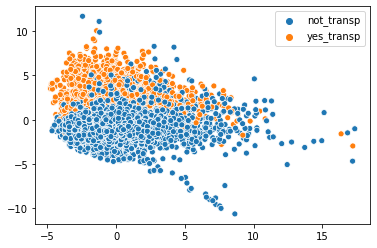

time: 888 ms


In [0]:
classify(df)

Tamanho do modelo em KB

In [0]:
(os.path.getsize(BASE_PATH + 'linearsvc_transp_resto_alvaro.pkl')/1024)

1.1484375

time: 2.86 ms
